 # Part 2: Building an NDT for Next-Generation WLANs with traditional AI/ML/DL

This notebook will process the provided dataset to create a NDT using techniques such as Convolutional Neural Networks(CNNs) and Feed Forward Neural Networks (FNNs). The dataset was created for the 2020 edition of the [ITU AI for 5G Challenge](https://challenge.aiforgood.itu.int/) in the wireless throughput prediction statement. The dataset was created using [Komondor](https://github.com/wn-upf/Komondor), a simulator for next-generation, high-density WLANs which includes novel functionalities such as channel bonding and spatial reuse. The generated data includes simulated data from IEEE 802.11 WLAN deployments applying Dynamic Channel Bonding, using different random parameters, including channel allocation, location of nodes, and number of STAs per AP. The original dataset can be found in [here](https://doi.org/10.5281/zenodo.4106127). Then, the dataset was parsed using the file ```parse_original_dataset.py``` and then uploaded to Google Drive.  We include a fixed 80/20 split, where, from the original dataset (600 deployments in total), 80% of the deployments were used for training and while the remaining 20% was used for validation.

We start by importing the necessary libraries. To build the CNN and the FNN model, we are using Tensorflow and Keras. Additionally, we are using scikit-learn to build the Gradient Boost regressor.

In [1]:
# Standard python libraries.
import os
import sys

from pathlib import Path
import math
import random
import pickle

# General data science libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Deep learning libraries.
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# now we can import all the functions from the auxiliaries' folder.
sys.path.append('../')
from auxiliaries.dataset_ml import NDTDataset

Then, we proceed to download, extract, and accommodate the dataset in a proper format to be used by the different ML models we create later.

In [2]:
########################################################################################################################
# Dataset.
########################################################################################################################

root = './datasets/NDTDataset/ml'

# Create Datasets
Data = NDTDataset(root)

./datasets/NDTDataset/ml/raw/view?usp=sharing


Downloading...
From (original): https://drive.google.com/uc?id=1mrsZ-HlkZCAVT8ajo_wWcCREl5D2gIJ3
From (redirected): https://drive.google.com/uc?id=1mrsZ-HlkZCAVT8ajo_wWcCREl5D2gIJ3&confirm=t&uuid=0b2a79ff-b255-4b6c-8569-d5292c1ebae8
To: /Users/mcamelo/Development/gnn-tutorial/notebooks/datasets/NDTDataset/ml/raw/view?usp=sharing
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3.46M/3.46M [00:00<00:00, 16.9MB/s]


./datasets/NDTDataset/ml/raw/view?usp=sharing
Extracting ./datasets/NDTDataset/ml/raw/view?usp=sharing
Processing train split.
Processing valid split.
Processing test split.


The dataset is comprised from two kind of files, one is the "input_node_files.csv" which contains the deployment information and their respective configuration (e.g., channels bonded, node location, WLAN code). This information is given to Komondor which simulates 100 seconds of transmission and the output from the simulator is given in the "output_simulator" files (e.g., airtime, obtained throughput, interference and measured SINR and RSSI). We use content from both files to compose the feature matrix. The features taken from the original dataset are the following.

1. 'device_type': the considered device is an AP (0) or a STA (1).
2. 'device_x_coordinate': the x coordinate of the device spatial position.
3. 'device_y_coordinate': the y coordinate of the device spatial position.
4. 'device_primary_channel': the primary channel of the AP.
5. 'min_channel_allowed': the minimum channel allowed to perform channel bonding.
6. 'max_channel_allowed': the maximum channel allowed to perform channel bonding.
7. 'sinr': the obtained Signal plus Interference to Noise Ratio (SINR) between the AP and the STA. The feature is 0 for AP devices.
8. 'mean_airtime': the mean percentage of airtime given by the used channel.
9. 'mean_interference': the mean measured interferences between APs.
10. 'rssi': the obtained Received Signal Strength Indicator (RSSI) between the AP and the STA. The feature is 0 for AP devices.
11. 'distance_to_ap': the euclidean distance between AP and STA. The feature is 0 for AP devices.
12. 'bandwidth': the total bandwidth used. We consider 20 MHz per used channel.

We created a dataset that contains only the STAs, another just containing the APs and another containing all the devices. For this tutorial we will use the dataset which uses only the STAs for the computation. During its processing we encode the channel configuration ('device_primary_channel', 'min_channel_allowed', 'max_channel_allowed') using one hot encoder, which extends it into a vector of six positions. Moreover, if the model we will build is a CNN, then we have to perform a reshaping. Let's load the dataset in memory.

In [3]:
# Select the dataset you want to use.
DATASET = "sta"
MODEL = "xgb"

# Load Train Dataset
data_name = 'data_%s.npz' % DATASET
data_path = os.path.join(Data.processed_dir, 'train', data_name)
print(f'Loading {data_path}')
with np.load(data_path) as data:
    x_name = 'x_%s' % DATASET
    y_name = 'y_%s' % DATASET
    train_examples = data[x_name]
    if MODEL == 'cnn':
        # additionally, if you want to use the CNN model, then the samples must be reshaped.
        train_examples = np.reshape(train_examples, (train_examples.shape[0], train_examples.shape[1], 1))
    train_labels = data[y_name]

# Load Validation Dataset
data_name = 'data_%s.npz' % DATASET
data_path = os.path.join(Data.processed_dir, 'valid', data_name)
print(f'Loading {data_path}')
with np.load(data_path) as data:
    x_name = 'x_%s' % DATASET
    y_name = 'y_%s' % DATASET
    valid_examples = data[x_name]
    if MODEL == 'cnn':
        # additionally, if you want to use the CNN model, then the samples must be reshaped.
        valid_examples = np.reshape(valid_examples, (valid_examples.shape[0], valid_examples.shape[1], 1))
    valid_labels = data[y_name]

# Load Test Dataset
data_name = 'data_%s.npz' % DATASET
data_path = os.path.join(Data.processed_dir, 'test', data_name)
print(f'Loading {data_path}')
with np.load(data_path) as data:
    x_name = 'x_%s' % DATASET
    y_name = 'y_%s' % DATASET
    sce_name = 'sce_%s' % DATASET
    dpl_name = 'dpl_%s' % DATASET
    id_name = 'ids_%s' % DATASET
    ap_name = 'aps_%s' % DATASET

    test_examples = data[x_name]
    if MODEL == 'cnn':
        # additionally, if you want to use the CNN model, then the samples must be reshaped.
        test_examples = np.reshape(test_examples, (test_examples.shape[0], test_examples.shape[1], 1))
    test_labels = data[y_name]
    test_scenarios = data[sce_name]             # array of the scenario where the test device belongs to, e.g., sce_1
    test_deployments = data[dpl_name]           # array of the deployment where the test device belongs to, e.g., deployment 0
    test_ids = data[id_name]                    # array with the id of all test devices
    test_aps = data[ap_name]                    # array with the id of the APs in the test set


Loading ./datasets/NDTDataset/ml/processed/train/data_sta.npz
Loading ./datasets/NDTDataset/ml/processed/valid/data_sta.npz
Loading ./datasets/NDTDataset/ml/processed/test/data_sta.npz


We can observe our dataset.

In [4]:
print(f'Train samples shapes: ')
print(f'Input shape: {train_examples.shape}')
print(f'Target shape: {train_labels.shape}')
print(f' ')
print(f'Validation samples shapes: ')
print(f'Input shape: {valid_examples.shape}')
print(f'Target shape: {valid_labels.shape}')
print(f' ')
print(f'Test samples shapes: ')
print(f'Input shape: {test_examples.shape}')
print(f'Target shape: {test_labels.shape}')

Train samples shapes: 
Input shape: (57293, 15)
Target shape: (57293,)
 
Validation samples shapes: 
Input shape: (14785, 15)
Target shape: (14785,)
 
Test samples shapes: 
Input shape: (8431, 15)
Target shape: (8431,)


We are now ready to start to build our ML models. Remember that a typical ML model has a fixed input size, depending on the feature matrix. In our case, we propose three models, one Feed Forward Neural Network (FNN), one Convolutional Neural Network (CNN), and a Gradient Boost (xGB) Regressor. The FNN model has three dense (Fully Connected) layers, whose hidden units decreases in an exponential scale (e.g., 32, 16, 8). The CNN model has two 1D convolutional layers since we don't have an extra dimension (e.g., time) in our data in which we could operate. In general, the first layer (dense or convolutional), matches the input of the data (e.g., BATCH_SIZE X 15). The last layers of the CNN model are fully connected, therefore, the first two layers perform the feature extraction, and the last layers perform the prediction. All layer use ReLU as activation function. The last layer has dimension 1, since we are trying to predict only one value (i.e., throughput). The architecture of both models was found following a trial and error strategy. For the xGB, we used the default parameters given from scikit-learn.

In [5]:
########################################################################################################################
# Define model's architecture
########################################################################################################################

def build_model_fnn(num_input, num_hidden, dropout=0.05):
    root = int(math.log2(num_hidden))
    num_hidden_half = 2**(root - 1)
    num_hidden_fourth = 2**(root - 2)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_hidden, kernel_initializer='normal', activation='relu', input_shape=(num_input,)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_hidden_half, kernel_initializer='normal', activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_hidden_fourth, kernel_initializer='normal', activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
        ])
    return model


def build_model_cnn(num_input, num_hidden, dropout=0.05, kernel_size=3, num_hidden_dense=8, num_hidden_dense_2=8):
    model = tf.keras.Sequential()
    # conv 1
    model.add(
        tf.keras.layers.Conv1D(
            num_hidden,
            kernel_size=kernel_size,
            padding='same',
            activation='relu',
            input_shape=(num_input, 1)
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    # conv 2
    model.add(
        tf.keras.layers.Conv1D(
            num_hidden,
            kernel_size=kernel_size,
            padding='same',
            activation='relu'
        )
    )
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout))
    # Dense 1
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_hidden_dense, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    # Dense 2
    model.add(tf.keras.layers.Dense(num_hidden_dense_2, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout))
    # Dense 3
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    return model

def build_gb_model():
    reg = GradientBoostingRegressor()
    return reg

Then, we can set up the configuration we want. For example, we can select the number of initial hidden units for the intermediate layers, the number of training epochs, the log interval and the directory where we want to save our best model. The selected optimizer is adam, which gave the best performance during an exploratory analysis.

In [6]:
# Configuration

## Network Configuration
num_input = train_examples.shape[1]
NUM_HIDDEN = 16
# DROPOUT = 0.05
# KERNEL_SIZE = 3
# NUM_HIDDEN_DENSE = 8
# NUM_HIDDEN_DENSE_2 = 8

## Training Configuration
NUM_EPOCHS = 10
LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1
CHECKPOINT_DIR = "checkpoints/ml"
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 32

# Create model.
if MODEL == 'fnn':
    model = build_model_fnn(num_input, NUM_HIDDEN)
elif MODEL == 'cnn':
    model = build_model_cnn(num_input, NUM_HIDDEN)
else:
    model = build_gb_model()                #



Now we are ready to train our model. For saving the best model, we create a ModelCheckpoint callback, which is activated, once the validation loss is lower that the previous saved model. For the xGB, the model is saved every epoch.

In [7]:
model_path = os.path.join(CHECKPOINT_DIR, MODEL)
best_model_path = os.path.join(model_path, 'best_model')
Path(best_model_path).mkdir(parents=True, exist_ok=True)

if MODEL != "xgb":
    ########################################################################################################################
    # Training loop for FNN and CNN models
    ########################################################################################################################

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.summary()

    # Define Callbacks
    model_name = f"model_{DATASET}_{MODEL}.h5"
    print(f"best model will be saved under: {model_name}")
    path_checkpoint = os.path.join(best_model_path, model_name)
    # we only save the best model: if the monitored variable is lower than previously saved
    modelckpt_callback = ModelCheckpoint(
        monitor="val_loss",
        filepath=path_checkpoint,
        verbose=0,
        save_weights_only=True,
        save_best_only=True,
    )

    # Train model on dataset
    history = model.fit(
        x=train_examples,
        y=train_labels,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=2,
        validation_data=(valid_examples, valid_labels),
        callbacks=[modelckpt_callback]
    )
else:
    xgb_evaluation = []
    for epoch in range(NUM_EPOCHS):
        print(f"processing epoch : {epoch}")
        model.fit(train_examples, train_labels)
        y_pred = model.predict(valid_examples)
        rmse = mean_squared_error(valid_labels, y_pred, squared=False)
        xgb_evaluation.append(rmse)
        # save model to file
        model_name = f"model_{DATASET}_{MODEL}_{epoch}.dat"
        model_filename = os.path.join(best_model_path, model_name)
        pickle.dump(model, open(model_filename, "wb"))


processing epoch : 0


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 1


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 2


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 3


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 4


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 5


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 6


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 7


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 8


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


processing epoch : 9


/opt/anaconda3/envs/ndt-tutorial-latincom/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


We can now see how the performance during training was.

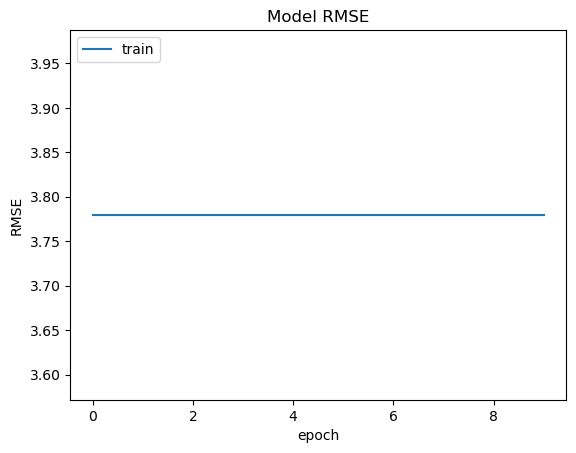

In [8]:
if MODEL != "xgb":
    ########################################################################################################################
    # Training history for FNN and CNN models
    ########################################################################################################################

    # summarize history for RMSE
    plt.plot(history.history['root_mean_squared_error'])
    plt.plot(history.history['val_root_mean_squared_error'])
    plt.legend(['train', 'validation'], loc='upper left')
else:
    plt.plot(xgb_evaluation)
    plt.legend(['train'], loc='upper left')

plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')

plt.show()


Remember that only ten epochs is too few to determine if the model is performing good or not. Thus, we need to train at least for 100 or even 1000 epochs to see if the model can lower the validation loss.

Now we can evaluate the model in the test dataset. For doing so, we need first to make predictions of the final throughput per device. Notice that, since we used the dataset that only has the STAs and not the APs, the AP's throughput must be actually calculated in an additional step. Moreover, if using the dataset that has all the devices (a.k.a. 'all'), might be that the throughput of the AP is not the sum of the throughput of its associated devices. The dataset that has only APs does not need to be post-processed and we cannot retrieve the throughput of the STAs.

In [9]:
# let's select where the weights of the best model were saved.
model_location = os.path.join(best_model_path, model_name)
# and where the prediction are going to be saved
predictions_location = os.path.join("predictions", model_name)

if MODEL != "xgb":
    # Load Model
    model.load_weights(model_location)
else:
    model = pickle.load(open(model_location, "rb"))

# Make Predictions --> Not aggregated throughput
sta_pred = model.predict(test_examples)
if MODEL == "xgb":
    #Reshape to add extra dimension
    sta_pred = sta_pred.reshape(-1,1)


# Add predictions to aggregated throughput of AP
total_devices = test_ids[-1] - test_ids[0] + 2
# new array that is going to save the throughput of all devices. Throughput of AP is aggregated by its associated STAs
thr_devices = np.zeros(total_devices)
scenarios = np.zeros(total_devices, dtype='<U9')
deployments = np.zeros(total_devices)
for associated_ap in np.unique(test_aps):
    thr_ap = 0
    ix_ap = associated_ap - test_aps[0]  # index AP in new array
    j = 1
    for i in range(len(test_aps)):
        if test_aps[i] == associated_ap:
            thr_ap += sta_pred[i][0]  # aggregated throughput AP
            thr_devices[ix_ap+j] = sta_pred[i][0] # throughput STA
            sce = test_scenarios[i]
            dpl = test_deployments[i]
            scenarios[ix_ap+j] = sce
            deployments[ix_ap+j]= dpl
            j += 1
    thr_devices[ix_ap] = thr_ap
    scenarios[ix_ap] = sce
    deployments[ix_ap] = dpl

# Visualize Results
thr_devices = thr_devices.reshape(-1, 1)
scenarios = scenarios.reshape(-1, 1)
deployments = deployments.reshape(-1, 1)
numpy_data = np.hstack([thr_devices, scenarios, deployments])
df = pd.DataFrame(data=numpy_data, columns=['thr_pred', 'scenario', 'deployment'])

# Divide and save predictions to CSV
grouped_df = df.groupby(['scenario', 'deployment'])
for key, item in grouped_df:
    sce, dpl = key[0], int(float(key[1]))
    group = grouped_df.get_group(key)
    predict_loc = os.path.join(predictions_location, sce)
    os.makedirs(predict_loc, exist_ok=True)
    predict_fn = 'throughput_{}.csv'.format(dpl)
    predict_loc = os.path.join(predict_loc, predict_fn)
    group.to_csv(predict_loc, columns=['thr_pred'], index=False)

Now that we have the predictions, we can take the Root Mean Square Error to evaluate the accuracy of the model. We will do it in only one deployment, but you can easily replicate for all the deployment.

In [10]:
# Select the scenario and the deployment to be evaluated.
possible_scenarios = ['test_sce1', 'test_sce2', 'test_sce3', 'test_sce4']
random_scenario = random.choice(possible_scenarios)
random_deployment = random.choice(range(50))        # there are 50 deployments per test scenario.
dpl_true = random_deployment + 1                    # the original files are from 1-50 while the predictions are from 0-49

print(f"Selected random scenario: {random_scenario}")
print(f"Selected random deployment: {random_deployment}")

Selected random scenario: test_sce2
Selected random deployment: 23


Then, we can proceed to load the the real values and compare them to the predicted values for the selected scenario.

In [11]:
# load the real values
true_thr_location = os.path.join("datasets", "NDTDataset", "ml", "raw", "test", "output_simulator", random_scenario + "_output", "throughput_"+ str(dpl_true) + ".csv")
true_thr = pd.read_csv(true_thr_location, header=None)
true_thr = true_thr.T[0].to_list()

# load predicted values
predicted_thr_location = os.path.join("predictions", model_name, random_scenario, "throughput_"+ str(random_deployment) + ".csv")
predicted_thr = pd.read_csv(predicted_thr_location)
predicted_thr = predicted_thr["thr_pred"].to_list()

The Root Mean Square Error (RMSE) is a risk function that helps us determine the average squared difference between the predicted and the actual value of a feature or variable. Usually, a RMSE score of less than 180 is considered a good score for a moderately or well working algorithm. In case, the RMSE value exceeds 180, we need to perform feature selection and hyper parameter tuning on the parameters of the model.

In [12]:
MSE = np.square(np.subtract(true_thr,predicted_thr)).mean()
RMSE = math.sqrt(MSE)
print(f"Root Mean Square Error: {RMSE}")

Root Mean Square Error: 34.62298756042945
